# Line 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import multiprocess as multi
try:
    multi.set_start_method('spawn')
except RuntimeError:
    print('couldn\'t set context')
    
# autoreload stopped working after an update
# this is the workaround
import config, master, standard_options, parallel
from config           import *
from master           import *
from standard_options import *
from parallel         import _parmap, helper, try_variations

# If runnign parallel jobs, limit cores/job to 1
# Disable logging (too verbose)
limit_cores()
debug = False
master.PRINT_LOGGING = not debug

from_list = matplotlib.colors.LinearSegmentedColormap.from_list

# Simulate different geometries 

Shuffling job sequence
Parallel using 64 cores
>>> 64 cores available.
>>> limited each process to 1 cores.
Preparing to run 5 jobs
Starting...
[████████████████████████████████████████]100.200% 

<IPython.core.display.Javascript object>

    main: fig T=1005 Δ=5 t=[  25  200 1000]                                     
    main: fig t/Δ=[  5  40 200]                                                 
1 connected components
1 connected components
1 connected components
1 connected components
1 connected components
1 connected components


<IPython.core.display.Javascript object>

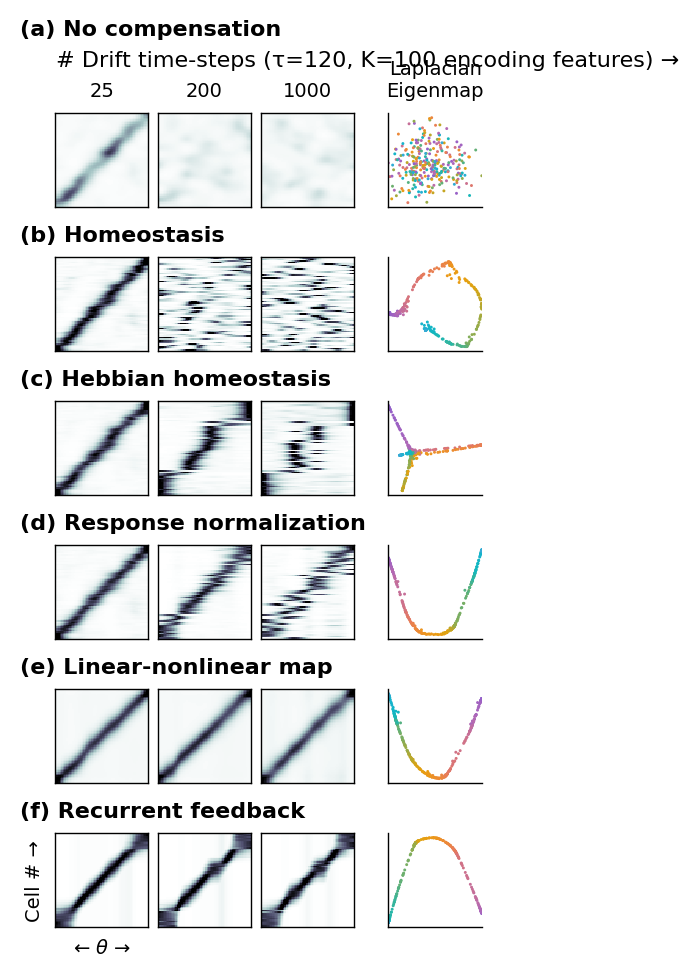

Shuffling job sequence
Preparing to run 5 jobs
Starting...
[████████████████████████████████████████]100.200% 

<IPython.core.display.Javascript object>

    main: fig T=1005 Δ=5 t=[  25  200 1000]                                     
    main: fig t/Δ=[  5  40 200]                                                 
1 connected components
2 connected components
1 connected components
1 connected components
1 connected components
1 connected components


<IPython.core.display.Javascript object>

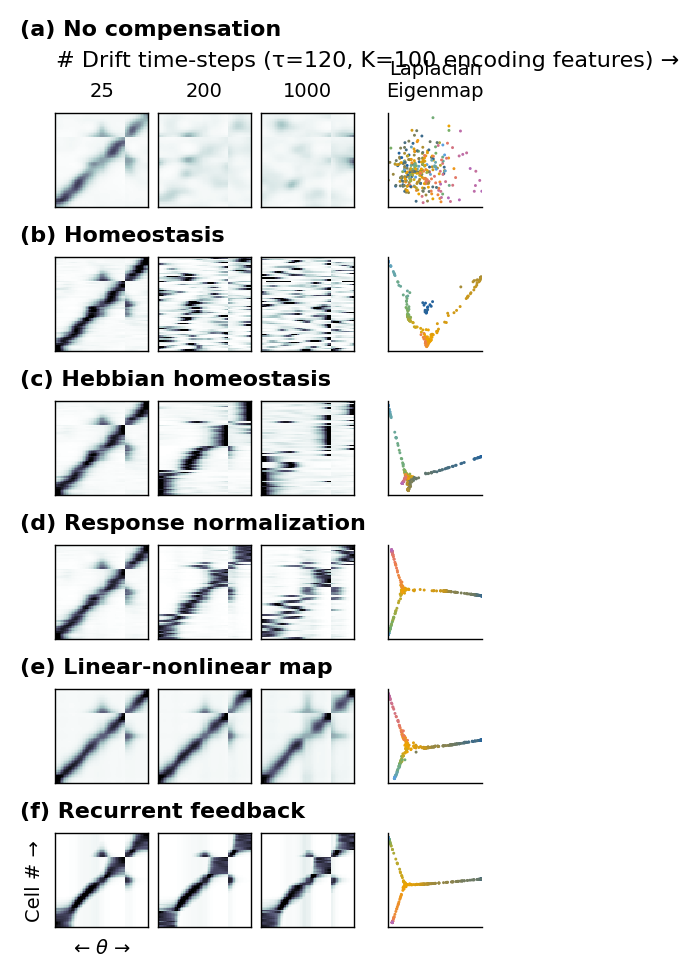

Shuffling job sequence
Preparing to run 5 jobs
Starting...
[████████████████████████████████████████]100.200% 

<IPython.core.display.Javascript object>

    main: fig T=1005 Δ=5 t=[  25  200 1000]                                     
    main: fig t/Δ=[  5  40 200]                                                 
1 connected components
1 connected components
1 connected components
1 connected components
1 connected components
1 connected components


<IPython.core.display.Javascript object>

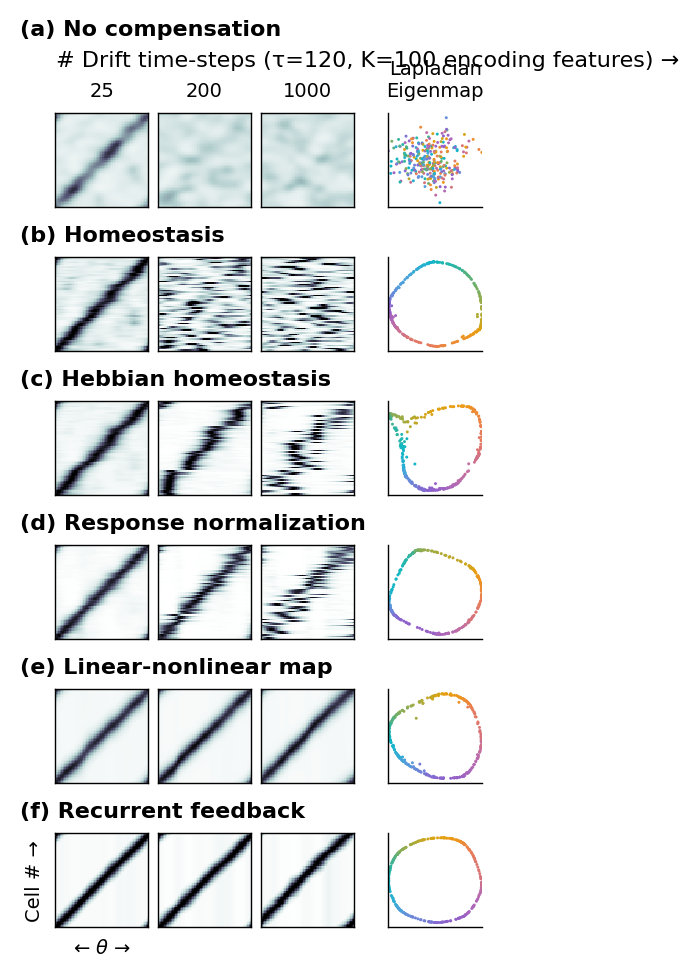

In [2]:
# Plot and spectral embedding configuration
σnoise      = 0.012
dx  ,dy     = 35,15
vmin,vmax   = 0,.05
ishow       = int32([25, 200, 1000])
resamples   = 5
n_neighbors = 20

def do_sim(geo):
    opts = {**options,
        'features':'ougaussian',
        'readout' :geo,
        'geometry':geo,
        'saveall' :True}
    results = _parmap(helper,[
        {**opts,'method':'homeostat' ,'normalize':False, **homeostat_rates},
        {**opts,'method':'hebbhomeo' ,'normalize':False, **hebb_rates     },
        {**opts,'method':'hebbhomeo' ,'normalize':True , **hebb_rates     },
        {**opts,'method':'recurrent' ,'normalize':True , **map_rates      },
        {**opts,'method':'predictive','normalize':True , **feedback_rates }])
    # Collect results and simulate fixed readout
    λh,λb,λc,λr,λp  = [array(p[3]) for p in results]
    W0,X,Y0,Y,W,R,G,B = results[0]
    tt = arange(opts['Δ']-1,(shape(W)[0]-1)*opts['Δ'],opts['Δ'])
    λ0 = sexp(einsum('km,tkl->tml',W0,[X[0]]+[*X[tt,:,:]]))
    return tt,λ0,λh,λb,λc,λr,λp

Δ = options['Δ']
T = options['T']
K = options['K']
L = options['L']
τ = options['τ']

# Prepare spectral embedding
from scipy.spatial.distance import pdist, squareform
from sklearn import manifold
se = manifold.SpectralEmbedding(
    n_components= 2,
    n_neighbors = n_neighbors,
    affinity    = 'precomputed')

# Imshow wrapper
def ish(λ):
    imshow(λ,vmin=vmin,vmax=vmax,aspect=1); nox(); noy();

for geo in ('line','tee','ring'):
    # Simulate all scenarios
    tsaved,λ0,λh,λb,λc,λr,λp = do_sim(geo)
    notify(geo+' finished simulating')
    
    LOG('fig T=%d Δ=%d t=%s'%(T,Δ,ishow),newline=True)
    LOG('fig t/Δ=%s'%(ishow//Δ))
    
    # Plot it
    figure(figsize=(PNAS_LARGE_WIDTH/3,4.8),dpi=200)
    subplots_adjust(top=0.9,wspace=0.1,bottom=0.025,right=0.9,left=0.04)
        
    todo = [
        (λ0,'No compensation'       ),
        (λh,'Homeostasis'           ),
        (λb,'Hebbian homeostasis'   ),
        (λc,'Response normalization'),
        (λr,'Linear-nonlinear map'  ),
        (λp,'Recurrent feedback'    )]
    nrow = len(todo)
    ncol = len(ishow)+1
    
    # Plot each result
    ax = {}
    for c,i in enumerate(ishow):    
        for r,(λ,_) in enumerate(todo):
            ax[r,c] = subplot2grid((nrow,ncol),(r,c))
            ish(λ[i//Δ,:,:])
            
    # Add titles and labels
    for c,i in enumerate(ishow):
        sca(ax[0,c])
        title('%d'%((i//Δ)*Δ))
    for r in range(len(todo)):
        sca(ax[r,0])
        subfigurelabel(("(%s) "%('abcdef'[r]))+todo[r][1],fontsize=8,dx=dx,dy=dy+(r==0)*80)
    sca(ax[0,0])
    text(0,ylim()[1]+30,'# Drift time-steps (τ=%d, K=%d encoding features) →'%(τ,K),fontsize=LARGE)
    sca(ax[5,0])
    xlabel('← $\\theta$ →')
    ylabel('Cell # →')
    
    # Select colors for spectral embedding based on geometry
    if geo=='tee':
        colors  = [ncl.MAUVE,ncl.RUST,ncl.OCHRE,ncl.MOSS,ncl.AZURE]
        colors2 = [ncl.DUSK,ncl.OCHRE]
        tee     = from_list('tee' ,colors )
        tee2    = from_list('tee2',colors2)
        La      = L//4
        colors  = \
            [*tee2(linspace( 0, 1, L-2*La))]+\
            [*tee (linspace(.5, 1, La    ))]+\
            [*tee (linspace(.5, 0, La    ))]
    elif geo=='ring':
        colors = [*riley(linspace(0,1,L+1)[:-1])]
    elif geo=='line':
        colors = [*riley(linspace(0,.8,L))]
    colors  = array(colors * resamples)

    # Render spectral embeddings
    c = ncol-1
    for r,(λ,_) in enumerate(todo):
        ax[r,c] = subplot2grid((nrow,ncol),(r,c),facecolor=(0,)*4)
        λ = λ[-1]#clip(λ[-1],vmin,vmax)
        
        # Resample with noise
        x0 = array([(λ+randn(*shape(λ))*σnoise).T for i in range(resamples)])
        x  = x0.reshape(resamples*L,L)

        # Get adjacency graph and fit spectral embedding
        D = squareform(pdist(x))
        p = n_neighbors/D.shape[0]*100
        q = D < percentile(D,p,axis=1)[:,None]
        A = float32(q | q.T)
        n_components, component_idxs = scipy.sparse.csgraph.connected_components(A)
        print('%d connected components'%n_components)
        biggest = np0.argmax([sum(component_idxs == i) for i in range(n_components)])
        idxs = component_idxs == biggest
        A = A[idxs,:][:,idxs]
        q  = se.fit_transform(A)
        
        # Plot and clean up
        scatter(*q.T,c=colors[idxs],s=4.5,marker='.',lw=0)
        simpleaxis(); xticks([]); yticks([]); force_aspect()
        nudge_axis_x(25)
        if r==0:
            title('Laplacian\nEigenmap',fontsize=7)
            
    savefigure('s4-'+geo,stamp=False)
    notify(geo+' finished plotting')
    show()